In [2]:
# Just a little hack to change font size for Markdown cells
from IPython.core.display import Javascript, display

def set_markdown_font():
    javascript = """
    var _render = IPython.MarkdownCell.prototype.render;

    if (_render.decorator === undefined) {
      IPython.MarkdownCell.prototype.render = function () {
        this.element.find('.rendered_html p').css('font-size', '20px');
        return _render.apply(this, arguments);
      }
      IPython.MarkdownCell.prototype.render.decorator = true;
    }
    """
    display(Javascript(data=javascript))

set_markdown_font()

<IPython.core.display.Javascript object>

# Overview

Deep Neural Networks are highly expressive machine learning networks that have been around for many decades.
The advancements in Computer Vision with Deep Learning has been constructed and perfected with time, primarily over one particular algorithm — a Convolutional Neural Network.

Goodfellow (do you know who is this guy?) et al. published a paper [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) in 2014 showing that adding imperceptible perturbations to an image can cause drastically different model performance.

Given this tutorial, we will explore the topic via example on an image classifier. Specifically we will use one of the first and most popular attack methods, the Fast Gradient Sign Attack (FGSM), to fool an MNIST classifier.

In general the overall goal of an attacker is to add the least amount of perturbation to the input data to cause the desired misclassification.

There are several kinds of assumptions of the attacker’s knowledge, two of which are:
- **white-box**
- **black-box**.

A *white-box* attack assumes the attacker has full knowledge and access to the model, including architecture, inputs, outputs, and weights.

A *black-box* attack assumes the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights.

There are also several types of goals and one of the most popular is **misclassification**. It can be targeted or untargeted.

An  *untargeted misclassification* means the adversary only wants the output classification to be wrong but does not care what the new classification is.

A *targeted misclassification* means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.

One of the first and most popular adversarial attacks to date is referred to as the **Fast Gradient Sign Attack** (FGSM) and is described in the beforementioned paper.

The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, *gradients*.

The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack *adjusts the input data to maximize the loss* based on the same backpropagated gradients.

Let’s look at the famous FGSM panda example

![This is not a panda](fgsm_panda_image.png)

The attack backpropagates the gradient back to the input data to calculate gradient of _y_ with respect to *x*.

Then, it adjusts the input data by a small step (ϵ or 0.007 in the picture) in the direction of gradient
(notice that we take only **sign**, not gradient values) that will maximize the loss.

The resulting perturbed image, *x*, is then misclassified by the target network as a “gibbon” when it is still clearly a “panda”.

# Model definition

Below is an implementation of the [LeNet](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) architecture for the MNIST dataset.

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  True


Of note: This notebook uses only a single GPU.
PyTorch can run models on several GPU, try to search how to specify several GPUs and create several devices.

In [6]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Lazy way

You can download weights of already pretrained model or train a network from scratch to see how long does it take
and how accuracy of the model changes during the training.

Notice that a model will work in *evulation mode*, i.e. weigths are not trainable and dropout is not applied.

In [ ]:
# Load the pretrained model
pretrained_model = 'lenet/mnist-model.pth'

import os
os.makedirs('lenet', exist_ok=True)

import requests
url = 'https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing'

r = requests.get(url)
with open(pretrained_model, 'wb') as f:
    f.write(r.content)

model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

## Master way

Or inspect code for training a model

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=128, shuffle=True)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
epoch_num = 20
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Remember a line with model.to(device)?
        # It moves a model to a GPU and PyTorch expects that
        # input data also will be on the GPU where the model resides
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Calculate the error between model predictins and actual labels
        loss = criterion(outputs, labels)
        
        # Initiate backward propagation
        loss.backward()
        
        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}: batch {i + 1}] loss: {running_loss / 200}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1: batch 200] loss: 2.29689067363739
[Epoch 1: batch 400] loss: 2.2543172562122344
[Epoch 2: batch 200] loss: 1.8467320364713669
[Epoch 2: batch 400] loss: 1.2419190138578415
[Epoch 3: batch 200] loss: 0.8894288828969001


KeyboardInterrupt: 

Let's check how accurate is our network

In [10]:
data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=256)

In [11]:
# Prevent training
model.eval()

total_correct = 0
avg_loss = 0.0

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    output = model(inputs)
    avg_loss += criterion(output, labels).sum()
    
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad.
    # It detaches the output from the computational graph.
    # So no gradient will be backpropagated along this variable.
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()

avg_loss /= len(data_test)
avg_loss = avg_loss.detach().cpu().item()
accuracy = float(total_correct) / len(data_test)
print(f'Test Avg. Loss: {avg_loss}, Accuracy: {accuracy}')


Test Avg. Loss: 0.0018136295257136226, Accuracy: 0.8702


In [12]:
# Save model state for re-use
my_awesome_model = 'my-lenet.pth'
torch.save(model.state_dict(), my_awesome_model)

**End of training code**

**FGSM Attack**

The fgsm_attack function takes three inputs: image is the original clean image (x), epsilon is the pixel-wise perturbation amount (ϵ), and data_grad is gradient of the loss w.r.t the input image.

The function then creates perturbed image as

$$\text{perturbed image} = image + epsilon * sign(gradient) = x + ϵ ∗ sign(∇xJ(θ,x,y))$$

In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [14]:
 # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist',
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)

Test function performs a full test step on the MNIST test set and reports a final accuracy.

For each sample in the test set, the function computes the gradient of the loss w.r.t the input data (data_grad),  creates a perturbed image with fgsm_attack (perturbed_data), then checks to see if the perturbed example is adversarial. 

In [15]:
def test( model, device, test_loader, epsilon, iterative=False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        
        if iterative:
            num_iterations = 10
        else:
            num_iterations = 1
        
        # If iterative is True, then do attack 10 times to each sample  
        for _ in range(num_iterations):
            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True
            
            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() != target.item():
                continue

            # Calculate the loss - Negative Log Likehood
            # Loosely explained at https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            data = fgsm_attack(data, epsilon, data_grad)
            
            # Remove newly generated adversarial data from PyTorch graph
            # Thats important not to create loop dependencies for the gradient when we will iterate
            data = data.detach()
            
        perturbed_data = data

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

# Let's attack!

In [16]:
accuracies = []
examples = []

# Epsilon 0 means no attack at all
epsilons = [0, .05, .1, .15, .2, .25, .3]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8702 / 10000 = 0.8702
Epsilon: 0.05	Test Accuracy = 7231 / 10000 = 0.7231
Epsilon: 0.1	Test Accuracy = 5340 / 10000 = 0.534
Epsilon: 0.15	Test Accuracy = 3485 / 10000 = 0.3485
Epsilon: 0.2	Test Accuracy = 1816 / 10000 = 0.1816
Epsilon: 0.25	Test Accuracy = 670 / 10000 = 0.067
Epsilon: 0.3	Test Accuracy = 177 / 10000 = 0.0177


The first result is the accuracy versus epsilon plot.

As epsilon increases we expect the test accuracy to decrease and it actually does. 

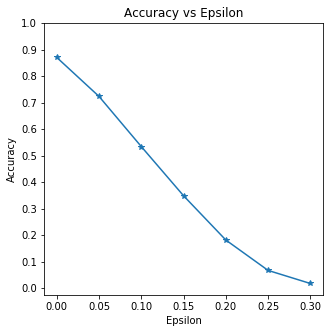

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, epsilons[-1] + 0.05, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

There is a tradeoff between accuracy degredation and perceptibility that an attacker must consider.  

Below are some examples of successful adversarial examples at each epsilon value.  
Each row of the plot shows a different epsilon value. The first row is the ϵ=0 examples which represent the original “clean” images with no perturbation. The title of each image shows the “original classification -> adversarial classification.”

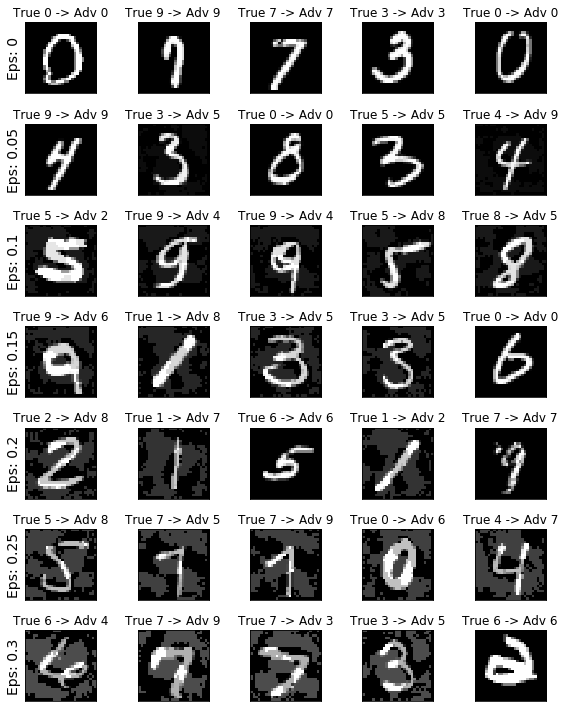

In [18]:
   # Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

##  Lets do iterative attack

In [ ]:
accuracies = []
examples = []

# Epsilon 0 means no attack at all
epsilons = [0.01, 0.05,]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, iterative=True)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.01	Test Accuracy = 5081 / 10000 = 0.5081


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, epsilons[-1] + 0.05, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
   # Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

Take a closer look at how we calculated gradient. 

In [ ]:
for data, target in test_loader:  
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    
    output = model(data)
    loss = F.nll_loss(output, target)
   
    model.zero_grad()
    loss.backward()

    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

The second parameter to the loss function is a true label of the current image. After that gradient is used for perturbation generation.
<br>
<br>
Remember that gradient is obtained for the whole image
pixels, namely gradient shape is equal to the image shape.  
In our case it's (28, 28, 1). So **each pixel gets own perturbation**.

Now recall how we apply gradient.

In [ ]:
sign_data_grad = data_grad.sign()
perturbed_image = image + epsilon * sign_data_grad

We add the scaled gradient to the original image. The result of this action is misclassification, but we don't know what label gain higher confidence. This is a case of *untargeted misclassification*.

*Targeted misclassification* implies that you add perturbation and model predicts one of the possible labels but not the correct one. For achieving this you should take gradient with respect to you selected label.

But it's not enough. Also, you should subtract scaled gradient instead of adding. Doing this we actually perform gradient descent on the loss function surface in direction to the target class. Remember that we want **to minimize** loss function with respect to **selected class**.

# PRACTICUM TASK

1 - For each class select 10 images not from this class. Perform attack to move selected images to this class. for each class select image with highest confidence.
    
Best sample is the one with higher confidence.

2 - Try different epsilons for one selected class and collect the number of iterations required to achieve success

3* OPTIONAL - make attacks using a model trained on Cifar10 obtained from the previous task.